### Scratch functions by Pytorch
scractch notebook to develop functions for pytorch code
- random rotation
- custom loss funciton

In [1]:
import os
import sys
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms

In [35]:
import matplotlib.pyplot as plt

##### download MNIST train data

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
      root="./multigrids/mnist_data",
      train=True,
      download=True,
      transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
      ])
    ),
    batch_size=32,
    shuffle=True,
    pin_memory=True
)

0.7%

100.1%

Extracting ./multigrids/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./multigrids/mnist_data/MNIST/raw


0.0%5%

Extracting ./multigrids/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./multigrids/mnist_data/MNIST/raw


180.4%

Extracting ./multigrids/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./multigrids/mnist_data/MNIST/raw
Extracting ./multigrids/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./multigrids/mnist_data/MNIST/raw
Processing...
Done!


In [5]:
train_loader

get data as computing type

In [15]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [16]:
example_data.shape

torch.Size([32, 1, 28, 28])

#### Code rotate fn

- rotate operation

In [25]:
rotate_ops= transforms.Compose([ 
                transforms.ToPILImage(),
                transforms.RandomRotation([1,359]),
            ])

In [32]:
rexample_data = []
for i in example_data:
    rexample_data.append(rotate_ops(i))

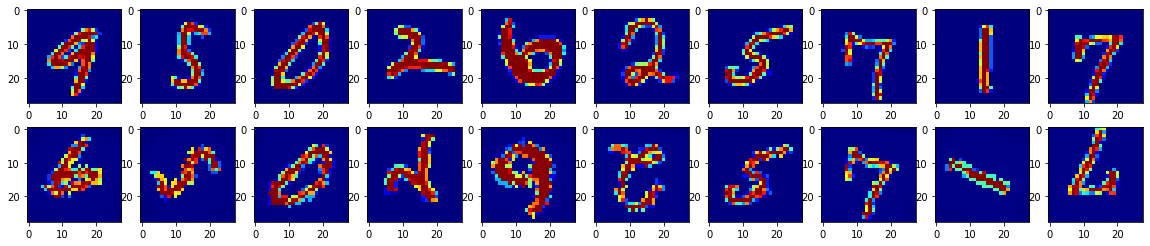

In [36]:
f,a=plt.subplots(2,10,figsize=(20,4))
for i in range(10):
    a[0][i].imshow(np.reshape(example_data[i],(28,28)), cmap='jet')
    a[1][i].imshow(np.reshape(rexample_data[i],(28,28)), cmap='jet')

In [62]:
def rotate_fn(data):
    rotate_ops= transforms.Compose([ 
                transforms.ToPILImage(),
                transforms.RandomRotation([1,359]),
                transforms.ToTensor()
            ])
    rdata = []
    for i in data:
        rdata.append(rotate_ops(i).unsqueeze(0)) # unsqueeze prevent depricated 1 dim entry
    return torch.cat(rdata)

In [63]:
a = rotate_fn(example_data)
print(type(a), type(example_data))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [64]:
a.shape

torch.Size([32, 1, 28, 28])

--------------------
#### Custo loss
[Custom Loss functirons](https://discuss.pytorch.org/t/custom-loss-functions/29387)

- Examples
```
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss
```

Rotate-Invariant Loss function by tesorflow

In [ ]:
### Tnesorflow version
def loss_torch_fn(output_layer,
                  input_layer,
                  encoded_imgs,
                  encoder,
                  batch_size=32, dangle=2, c_lambda=1
                  ):

    def rotate_opetation(imgs, angle=1):
        rimgs = []
        for img in imgs:
            rimgs.append(transforms.functional.rotate(img, angle).unsqueeze(0))
        return torch.cat(rimgs)

    # loss lists
    loss_reconst = [] # first term
    loss_hidden  = [] # seconds term
    angle_list = [i for i in range(1,360,dangle)]
    for angle in angle_list:
        rimgs = rotate_opetation(output_layer) # R_theta(x_hat)
        rencoded_imgs = rotate_opetation(rotate_opetation(input_layer)) # Z(R(x))

        # loss
        loss_reconst.append(torch.mean((input_layer - rimgs)**2) )
        loss_hidden.append(torch.mean((encoded_imgs - rencoded_imgs)**2))

    # Get min-max
    reconst = torch.min(torch.stack(loss_reconst))
    hidden  = torch.max(torch.stack(loss_reconst))

    return reconst + c_lambda*hidden

Translate to Pytorch

In [65]:
c = torch.randn(3,3)
c

tensor([[ 1.6189, -0.7738, -0.7542],
        [-0.4852, -0.3012,  1.5171],
        [ 0.4657, -0.0723, -0.4064]])

In [66]:
c*4

tensor([[ 6.4756, -3.0950, -3.0170],
        [-1.9406, -1.2048,  6.0686],
        [ 1.8626, -0.2891, -1.6254]])